In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Pre-reading material:**

1. https://web.archive.org/web/20200414113542/https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/
1. https://github.com/ultralytics/yolov3

In [ ]:
%%bash
wget https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3.cfg
mkdir -p config
mv yolov3.cfg ./config/

--2020-10-24 15:46:28--  https://raw.githubusercontent.com/ultralytics/yolov3/master/cfg/yolov3.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8338 (8.1K) [text/plain]
Saving to: ‘yolov3.cfg’

     0K ........                                              100% 44.1M=0s

2020-10-24 15:46:28 (44.1 MB/s) - ‘yolov3.cfg’ saved [8338/8338]



In [ ]:
%%bash

if [ ! -e "/content/config/yolov3.weights" ]; then
  cp "/content/gdrive/My Drive/development/ai/4-yolov3/yolov3.weights" /content/config/

  # wget https://pjreddie.com/media/files/yolov3.weights
  # mv yolov3.weights ./config/
else
  echo yolov3 weights already downloaded
fi

In [ ]:
%%bash
wget https://raw.githubusercontent.com/ultralytics/yolov3/master/data/coco.names
mv coco.names ./config/

--2020-10-24 15:46:35--  https://raw.githubusercontent.com/ultralytics/yolov3/master/data/coco.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 621 [text/plain]
Saving to: ‘coco.names’

     0K                                                       100% 35.0M=0s

2020-10-24 15:46:36 (35.0 MB/s) - ‘coco.names’ saved [621/621]



In [ ]:
%%bash
mkdir -p samples
wget https://raw.githubusercontent.com/ultralytics/yolov3/master/data/samples/bus.jpg
mv bus.jpg ./samples/
mkdir -p output

--2020-10-24 15:46:36--  https://raw.githubusercontent.com/ultralytics/yolov3/master/data/samples/bus.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487438 (476K) [image/jpeg]
Saving to: ‘bus.jpg’

     0K .......... .......... .......... .......... .......... 10% 1.88M 0s
    50K .......... .......... .......... .......... .......... 21% 3.91M 0s
   100K .......... .......... .......... .......... .......... 31% 10.9M 0s
   150K .......... .......... .......... .......... .......... 42% 16.5M 0s
   200K .......... .......... .......... .......... .......... 52% 5.16M 0s
   250K .......... .......... .......... .......... .......... 63% 9.24M 0s
   300K .......... .......... .......... .......... .......... 73% 8.63M 0s
   350K .......... .......... ........

In [3]:
from PIL import Image
def showImage(path, width):
  img = Image.open(path)
  wpercent = (width/float(img.size[0]))
  height = int((float(img.size[1])*float(wpercent)))
  return img.resize((width,height), Image.ANTIALIAS)

## Model Definition:

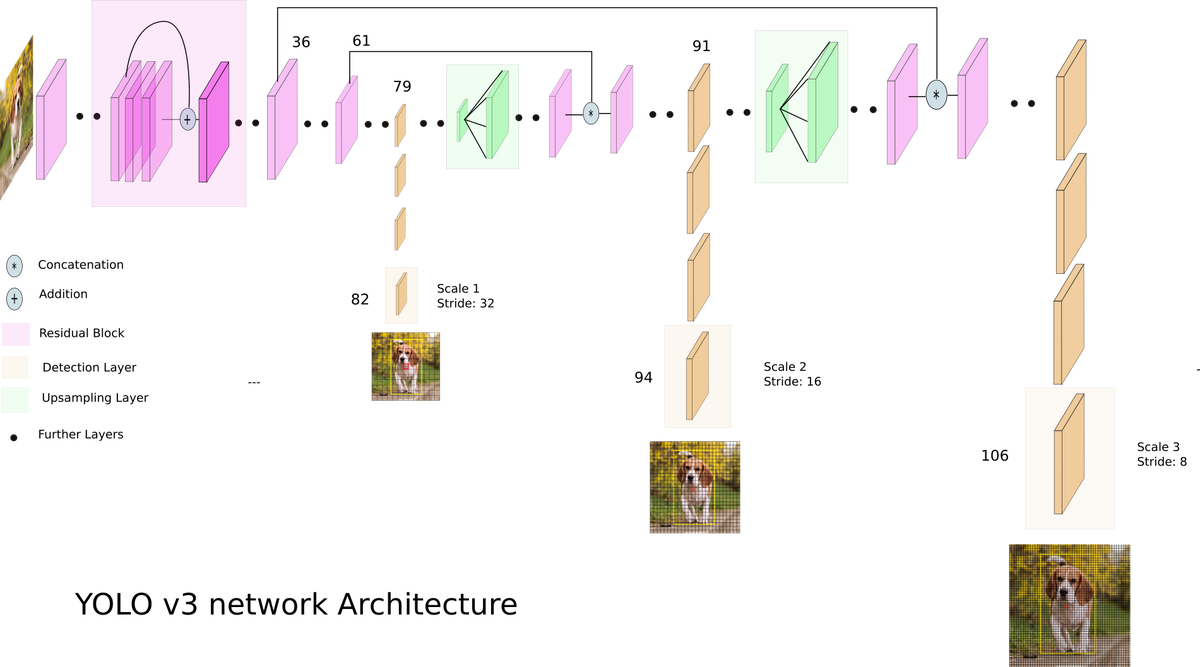

In [10]:
showImage('/content/gdrive/My Drive/development/ai/4-yolov3/readme/yolo-network.png', 1200)

Yolo v3 network is represented by a config file that represents the above network. This is created by the below code:

In [ ]:
def parse_model_cfg(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    with open(path, 'r') as f:
        lines = f.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    mdefs = []  # module definitions
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            mdefs.append({})
            mdefs[-1]['type'] = line[1:-1].rstrip()
            if mdefs[-1]['type'] == 'convolutional':
                mdefs[-1]['batch_normalize'] = 0  # pre-populate with zeros (may be overwritten later)
        else:
            key, val = line.split("=")
            key = key.rstrip()

            if key == 'anchors':  # return nparray
                mdefs[-1][key] = np.array([float(x) for x in val.split(',')]).reshape((-1, 2))  # np anchors
            elif (key in ['from', 'layers', 'mask']) or (key == 'size' and ',' in val):  # return array
                mdefs[-1][key] = [int(x) for x in val.split(',')]
            else:
                val = val.strip()
                # TODO: .isnumeric() actually fails to get the float case
                if val.isnumeric():  # return int or float
                    mdefs[-1][key] = int(val) if (int(val) - float(val)) == 0 else float(val)
                else:
                    mdefs[-1][key] = val  # return string

    return mdefs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def create_modules(module_defs, img_size):
    # Constructs module list of layer blocks from module configuration in module_defs

    img_size = [img_size] * 2 if isinstance(img_size, int) else img_size  # expand if necessary
    _ = module_defs.pop(0)  # cfg training hyperparams (unused)
    output_filters = [3]  # input channels
    module_list = nn.ModuleList()
    routs = []  # list of layers which rout to deeper layers

    for i, mdef in enumerate(module_defs):
        modules = nn.Sequential()

        if mdef['type'] == 'convolutional':
            bn = mdef['batch_normalize']
            filters = mdef['filters']
            k = mdef['size']  # kernel size
            stride = mdef['stride']
            modules.add_module(
                'Conv2d',
                nn.Conv2d(
                    in_channels=output_filters[-1],
                    out_channels=filters,
                    kernel_size=k,
                    stride=stride,
                    padding=k // 2 if mdef['pad'] else 0,
                    bias=not bn,
                ),
            )
            if bn:
                modules.add_module('BatchNorm2d', nn.BatchNorm2d(filters, momentum=0.03, eps=1E-4))
            if mdef["activation"] == "leaky":
                modules.add_module('activation', nn.LeakyReLU(0.1, inplace=True))

        elif mdef["type"] == "upsample":
            modules = nn.Upsample(scale_factor=mdef['stride'])

        elif mdef["type"] == "route":
            layers = mdef['layers']
            filters = sum([output_filters[l + 1 if l > 0 else l] for l in layers])
            routs.extend([i + l if l < 0 else l for l in layers])
            modules = FeatureConcat(layers=layers)

        elif mdef["type"] == "shortcut":
            layers = mdef['from']
            filters = output_filters[-1]
            routs.extend([i + l if l < 0 else l for l in layers])
            modules = FeatureFusion(layers=layers)

        elif mdef["type"] == "yolo":
            # Define detection layer
            modules = YOLOLayer(anchors=mdef['anchors'][mdef['mask']],  # anchor list
                                nc=mdef['classes'],  # number of classes
                                img_size=img_size)

        else:
            print('Warning: Unrecognized Layer Type: ' + mdef['type'])
          
        # Register module list and number of output filters
        module_list.append(modules)
        output_filters.append(filters)

    routs_binary = [False] * (i + 1)
    for i in routs:
        routs_binary[i] = True
    return module_list, routs_binary


In [ ]:
class FeatureConcat(nn.Module):
    def __init__(self, layers):
        super(FeatureConcat, self).__init__()
        self.layers = layers  # layer indices
        self.multiple = len(layers) > 1  # multiple layers flag

    def forward(self, x, outputs):
        return torch.cat([outputs[i] for i in self.layers], 1) if self.multiple else outputs[self.layers[0]]

In [ ]:
class FeatureFusion(nn.Module):
    def __init__(self, layers):
        super(FeatureFusion, self).__init__()
        self.layers = layers  # layer indices
        self.n = len(layers) + 1  # number of layers

    def forward(self, x, outputs):
        # Fusion
        nx = x.shape[1]  # input channels
        for i in range(self.n - 1):
            a = outputs[self.layers[i]]  # feature to add
            x = x + a
        return x

Per cell in the image below, we have multiple anchors (represented as Box 1, Box 2 and Box 3). Each anchor represents a bounding box, with box coordinates, objectiveness (1 or 0 if object is centered in this anchor) and class scores.

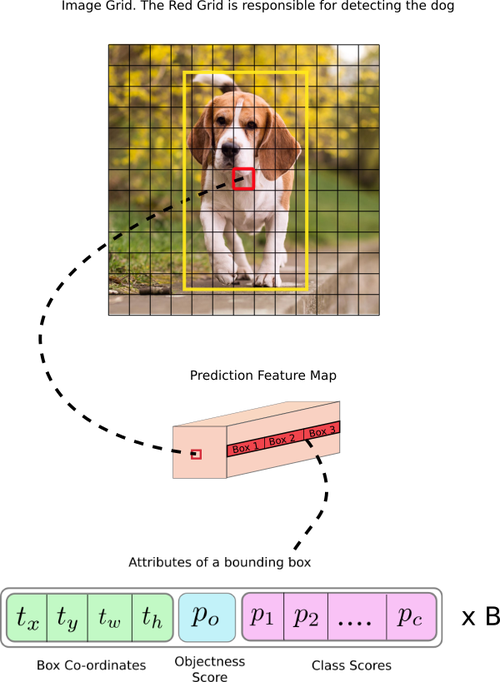

In [8]:
showImage('/content/gdrive/My Drive/development/ai/4-yolov3/readme/yolo-output.png', 500)

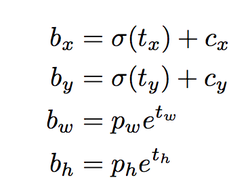

In [6]:
showImage('/content/gdrive/My Drive/development/ai/4-yolov3/readme/positions.png', 250)

In [ ]:
class YOLOLayer(nn.Module):
    """Detection layer"""

    def __init__(self, anchors, nc, img_size):
        super(YOLOLayer, self).__init__()
        self.anchors = torch.Tensor(anchors)
        self.img_size = img_size  # img_size[x,y]
        self.na = len(anchors)  # number of anchors (3)
        self.nc = nc  # number of classes (80)
        self.no = nc + 5  # number of outputs (85)
        self.nx, self.ny, self.ng = 0, 0, 0  # initialize number of x, y gridpoints

    def create_grids(self, ng=(13, 13), device='cpu'):
        self.nx, self.ny = ng  # x and y grid size

        self.stride = self.img_size[1] // self.ny
        self.anchor_vec = self.anchors / self.stride
        self.anchor_wh = self.anchor_vec.view(1, self.na, 1, 1, 2)

        # build xy offsets
        if not self.training:
            yv, xv = torch.meshgrid([torch.arange(self.ny, device=device), torch.arange(self.nx, device=device)])
            self.grid = torch.stack((xv, yv), 2).view((1, 1, self.ny, self.nx, 2)).float()

        if self.anchor_vec.device != device:
            self.anchor_vec = self.anchor_vec.to(device)
            self.anchor_wh = self.anchor_wh.to(device)
        
    def forward(self, p):
        # p = layer input (predictions)
        bs, _, ny, nx = p.shape  # bs, 255, 13, 13
        if (self.nx, self.ny) != (nx, ny):
            self.create_grids((nx, ny), p.device)

        p = p.view(bs, self.na, self.no, self.ny, self.nx).permute(0, 1, 3, 4, 2).contiguous()  # prediction

        if self.training:
            return p
        else:  # inference
            io = p.clone()  # inference output
            io[..., :2] = torch.sigmoid(io[..., :2]) + self.grid  # xy
            io[..., 2:4] = torch.exp(io[..., 2:4]) * self.anchor_wh  # wh yolo method
            io[..., :4] *= self.stride
            torch.sigmoid_(io[..., 4:]) # fit 0-1 class confidences
            return io.view(bs, -1, self.no), p  # view [1, 3, 13, 13, 85] as [1, 507, 85]


In [ ]:
def get_yolo_layers(model):
    return [i for i, m in enumerate(model.module_list) if m.__class__.__name__ == 'YOLOLayer']  # [89, 101, 113]

class Darknet(nn.Module):
    """YOLOv3 object detection model"""

    def __init__(self, cfg, img_size=(416, 416), verbose=False):
        super(Darknet, self).__init__()

        self.module_defs = parse_model_cfg(cfg)
        self.module_list, self.routs = create_modules(self.module_defs, img_size)
        self.yolo_layers = get_yolo_layers(self)

    def forward(self, x):
        return self.forward_once(x)
    
    def forward_once(self, x, augment=False, verbose=False):
        img_size = x.shape[-2:]  # height, width
        yolo_out, out = [], []

        for i, module in enumerate(self.module_list):
            name = module.__class__.__name__
            if name in ['FeatureFusion', 'FeatureConcat']:  # sum, concat
                x = module(x, out)  # WeightedFeatureFusion(), FeatureConcat()
            elif name == 'YOLOLayer':
                yolo_out.append(module(x))
            else:  # run module directly, i.e. mtype = 'convolutional', 'upsample', 'maxpool', 'batchnorm2d' etc.
                x = module(x)

            out.append(x if self.routs[i] else [])

        if self.training:  # train
          return yolo_out
        
        x, p = zip(*yolo_out)  # inference output, training output
        x = torch.cat(x, 1)  # cat yolo outputs
        return x, p


## Detection evaluation:

In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import glob
import numpy as np
import torchvision.transforms as transforms

def pad_to_square(img, pad_value):
    c, h, w = img.shape
    dim_diff = np.abs(h - w)
    # (upper / left) padding and (lower / right) padding
    pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
    # Determine padding
    pad = (0, 0, pad1, pad2) if h <= w else (pad1, pad2, 0, 0)
    # Add padding
    img = F.pad(img, pad, "constant", value=pad_value)

    return img, pad

def resize(image, size):
    c, h, w = image.shape
    image = F.interpolate(image.unsqueeze(0), size=size, mode="nearest").squeeze(0)
    return image, (size / h, size / w)

class ImageFolder(Dataset):
    def __init__(self, folder_path, img_size=416):
        self.files = sorted(glob.glob("%s/*.*" % folder_path))
        self.img_size = img_size

    def __getitem__(self, index):
        img_path = self.files[index % len(self.files)]
        # Extract image as PyTorch tensor
        # 0 - 255 to 0.0 - 1.0
        img = transforms.ToTensor()(Image.open(img_path))
        # Pad to square resolution
        img, _ = pad_to_square(img, 0)
        # Resize
        img, _ = resize(img, self.img_size)
        # print("loading img: ", img_path)
        # print(img)

        return img_path, img

    def __len__(self):
        return len(self.files)

In [ ]:
from pathlib import Path

def load_darknet_weights(self, weights, cutoff=-1):
    # Parses and loads the weights stored in 'weights'

    # Establish cutoffs (load layers between 0 and cutoff. if cutoff = -1 all are loaded)
    file = Path(weights).name

    # Read weights file
    with open(weights, 'rb') as f:
        # Read Header https://github.com/AlexeyAB/darknet/issues/2914#issuecomment-496675346
        self.version = np.fromfile(f, dtype=np.int32, count=3)  # (int32) version info: major, minor, revision
        self.seen = np.fromfile(f, dtype=np.int64, count=1)  # (int64) number of images seen during training

        weights = np.fromfile(f, dtype=np.float32)  # the rest are weights

    ptr = 0
    for i, (mdef, module) in enumerate(zip(self.module_defs[:cutoff], self.module_list[:cutoff])):
        if mdef['type'] == 'convolutional':
            conv = module[0]
            if mdef['batch_normalize']:
                # Load BN bias, weights, running mean and running variance
                bn = module[1]
                nb = bn.bias.numel()  # number of biases
                # Bias
                bn.bias.data.copy_(torch.from_numpy(weights[ptr:ptr + nb]).view_as(bn.bias))
                ptr += nb
                # Weight
                bn.weight.data.copy_(torch.from_numpy(weights[ptr:ptr + nb]).view_as(bn.weight))
                ptr += nb
                # Running Mean
                bn.running_mean.data.copy_(torch.from_numpy(weights[ptr:ptr + nb]).view_as(bn.running_mean))
                ptr += nb
                # Running Var
                bn.running_var.data.copy_(torch.from_numpy(weights[ptr:ptr + nb]).view_as(bn.running_var))
                ptr += nb
            else:
                # Load conv. bias
                nb = conv.bias.numel()
                conv_b = torch.from_numpy(weights[ptr:ptr + nb]).view_as(conv.bias)
                conv.bias.data.copy_(conv_b)
                ptr += nb
            # Load conv. weights
            nw = conv.weight.numel()  # number of weights
            conv.weight.data.copy_(torch.from_numpy(weights[ptr:ptr + nw]).view_as(conv.weight))
            ptr += nw

In [ ]:
import torchvision

def xywh2xyxy(x):
    # Convert nx4 boxes from [x, y, w, h] to [x1, y1, x2, y2] where xy1=top-left, xy2=bottom-right
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = x[:, 0] - x[:, 2] / 2  # top left x
    y[:, 1] = x[:, 1] - x[:, 3] / 2  # top left y
    y[:, 2] = x[:, 0] + x[:, 2] / 2  # bottom right x
    y[:, 3] = x[:, 1] + x[:, 3] / 2  # bottom right y
    return y

def xyxy2xywh(x):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] where xy1=top-left, xy2=bottom-right
    y = torch.zeros_like(x) if isinstance(x, torch.Tensor) else np.zeros_like(x)
    y[:, 0] = (x[:, 0] + x[:, 2]) / 2  # x center
    y[:, 1] = (x[:, 1] + x[:, 3]) / 2  # y center
    y[:, 2] = x[:, 2] - x[:, 0]  # width
    y[:, 3] = x[:, 3] - x[:, 1]  # height
    return y

def box_iou(box1, box2):
    # https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py
    """
    Return intersection-over-union (Jaccard index) of boxes.
    Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Arguments:
        box1 (Tensor[N, 4])
        box2 (Tensor[M, 4])
    Returns:
        iou (Tensor[N, M]): the NxM matrix containing the pairwise
            IoU values for every element in boxes1 and boxes2
    """

    def box_area(box):
        # box = 4xn
        return (box[2] - box[0]) * (box[3] - box[1])

    area1 = box_area(box1.t())
    area2 = box_area(box2.t())

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    # None creates extra dim! copy down!
    inter = (torch.min(box1[:, None, 2:], box2[:, 2:]) - torch.max(box1[:, None, :2], box2[:, :2])).clamp(0).prod(2)
    return inter / (area1[:, None] + area2 - inter)  # iou = inter / (area1 + area2 - inter)

def non_max_suppression(prediction, conf_thres=0.1, iou_thres=0.6, multi_label=True, classes=None, agnostic=False):
    """
    Performs  Non-Maximum Suppression on inference results
    Returns detections with shape:
        nx6 (x1, y1, x2, y2, conf, cls)
    """

    # Settings
    merge = True  # merge for best mAP
    min_wh, max_wh = 2, 4096  # (pixels) minimum and maximum box width and height

    output = [None] * prediction.shape[0]
    for xi, x in enumerate(prediction):  # image index, image inference
        # Apply constraints
        x = x[x[:, 4] > conf_thres]  # confidence
        # all(1) to reduce 2:4 into boolean:
        x = x[((x[:, 2:4] > min_wh) & (x[:, 2:4] < max_wh)).all(1)]  # width-height

        # If none remain process next image
        if not x.shape[0]:
            continue

        # Compute conf
        x[..., 5:] *= x[..., 4:5]  # conf = obj_conf * cls_conf

        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])

        # Detections matrix nx6 (xyxy, conf, cls)
        if multi_label:
            # torch.t() = transpose
            i, j = (x[:, 5:] > conf_thres).nonzero().t()
            # x = (x1, y1, x2, y2, conf, cls)
            x = torch.cat((box[i], x[i, j + 5].unsqueeze(1), j.float().unsqueeze(1)), 1)

        # If none remain process next image
        n = x.shape[0]  # number of boxes
        if not n:
            continue

        # Batched NMS
        c = x[:, 5]  # classes
        boxes, scores = x[:, :4].clone() + c.view(-1, 1) * max_wh, x[:, 4]  # boxes (offset by class), scores
        i = torchvision.ops.boxes.nms(boxes, scores, iou_thres)
        if merge and (1 < n < 3E3):  # Merge NMS (boxes merged using weighted mean)
            try:  # update boxes as boxes(i,4) = weights(i,n) * boxes(n,4)
                iou = box_iou(boxes[i], boxes) > iou_thres  # iou matrix (i,n)
                weights = iou * scores[None]  # box weights (i,n)

                # = (i,n) x (n, 4) = (i,4) / (i)
                x[i, :4] = torch.mm(weights, x[:, :4]).float() / weights.sum(1, keepdim=True)  # merged boxes
            except:  # possible CUDA error https://github.com/ultralytics/yolov3/issues/1139
                print(x, i, x.shape, i.shape)
                pass

        output[xi] = x[i]

    return output

In [ ]:
import time
import datetime
from torch.utils.data import DataLoader
import random
import cv2

img_size = 512
batch_size = 1
n_cpu = 0
conf_thres = 0.3
iou_thres = 0.6

def load_classes(path):
    # Loads *.names file at 'path'
    with open(path, 'r') as f:
        names = f.read().split('\n')
    return list(filter(None, names))  # filter removes empty strings (such as last line)

def plot_one_box(x, img, color=None, label=None, line_thickness=None):
    # Plots one bounding box on image img
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color)
    if label:
        t_size = cv2.getTextSize(label, 0, fontScale=1, thickness=2)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  # filled
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, 1, [225, 255, 255], thickness=2, lineType=cv2.LINE_AA)

def clip_coords(boxes, img_shape):
    # Clip bounding xyxy bounding boxes to image shape (height, width)
    boxes[:, 0].clamp_(0, img_shape[1])  # x1
    boxes[:, 1].clamp_(0, img_shape[0])  # y1
    boxes[:, 2].clamp_(0, img_shape[1])  # x2
    boxes[:, 3].clamp_(0, img_shape[0])  # y2

def scale_coords(img1_shape, coords, img0_shape, ratio_pad=None):
    print(img1_shape)
    # Rescale coords (xyxy) from img1_shape to img0_shape
    if ratio_pad is None:  # calculate from img0_shape
        gain = max(img1_shape) / max(img0_shape)  # gain  = old / new
        pad = (img1_shape[1] - img0_shape[1] * gain) / 2, (img1_shape[0] - img0_shape[0] * gain) / 2  # wh padding
    else:
        gain = ratio_pad[0][0]
        pad = ratio_pad[1]

    coords[:, [0, 2]] -= pad[0]  # x padding
    coords[:, [1, 3]] -= pad[1]  # y padding
    coords[:, :4] /= gain
    clip_coords(coords, img0_shape)
    return coords


def detect():
    # Initialize
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model
    model = Darknet("config/yolov3.cfg", img_size).to(device)

    load_darknet_weights(model, 'config/yolov3.weights')

    # Eval mode
    model.to(device).eval()

    # Set Dataloader
    dataloader = DataLoader(
        ImageFolder("samples", img_size=img_size),
        batch_size=batch_size,
        shuffle=False,
        num_workers=n_cpu,
    )
        
    names = load_classes('./config/coco.names')

    # Run inference
    print("\nPerforming object detection:")
    prev_time = time.time()
    for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
        print(img_paths)
        # print(input_imgs)
        input_imgs = input_imgs.to(device)

        # Get detections
        with torch.no_grad():
            detections = model(input_imgs)[0]
            detections = non_max_suppression(detections, conf_thres, iou_thres)

            # Process detections
            for i, det in enumerate(detections):  # detections for image i
                if det is not None and len(det):
                    img0 = cv2.imread(img_paths[i])  # BGR

                    # Rescale boxes from imgsz to im0 size
                    det[:, :4] = scale_coords(input_imgs[i].shape[1:], det[:, :4], img0.shape).round()

                    # Write results
                    for *xyxy, conf, cls in reversed(det):
                        label = '%s %.2f' % (names[int(cls)], conf)
                        plot_one_box(xyxy, img0, label=label)
                    cv2.imwrite('./output/'+Path(img_paths[i]).name, img0)
            print(detections)

        # Log progress
        current_time = time.time()
        inference_time = datetime.timedelta(seconds=current_time - prev_time)
        prev_time = current_time
        print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

detect()



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])
[tensor([[6.7700e+02, 4.3300e+02, 8.1000e+02, 8.9100e+02, 9.9941e-01, 0.0000e+00],
        [2.1900e+02, 4.0900e+02, 3.3700e+02, 8.5300e+02, 9.9908e-01, 0.0000e+00],
        [5.6000e+01, 4.1500e+02, 2.1600e+02, 8.7300e+02, 9.9884e-01, 0.0000e+00],
        [9.0000e+00, 2.2800e+02, 8.0300e+02, 7.8000e+02, 9.9170e-01, 5.0000e+00],
        [0.0000e+00, 5.6100e+02, 7.5000e+01, 8.7400e+02, 8.5701e-01, 0.0000e+00],
        [0.0000e+00, 2.6500e+02, 7.9300e+02, 8.3900e+02, 3.6128e-01, 7.0000e+00]],
       device='cuda:0')]
	+ Batch 0, Inference Time: 0:00:00.561272


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:77: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


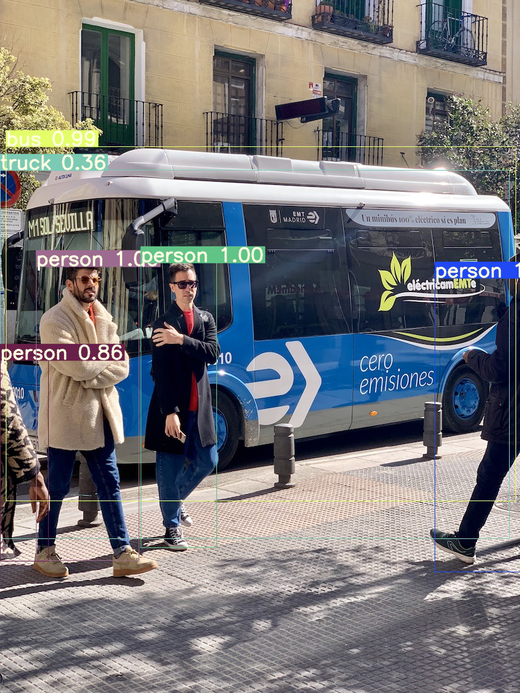

In [ ]:
def showImage(path, width):
  img = Image.open(path)
  wpercent = (width/float(img.size[0]))
  height = int((float(img.size[1])*float(wpercent)))
  return img.resize((width,height), Image.ANTIALIAS)

showImage("output/bus.jpg", 520)

## Model training:

Clone repository and download COCO 2014 dataset (20GB):

In [ ]:
%%bash

if [ ! -e "/content/coco" ]; then
  wget https://raw.githubusercontent.com/ultralytics/yolov3/master/data/get_coco2014.sh
  bash get_coco2014.sh
fi

# Dataset Output:
# ------------------------------
# coco/images/train2014/*.jpg
# coco/images/val2014/*.jpg
# coco/labels/train2014/*.txt
# coco/labels/val2014/*.txt

--2020-10-24 15:46:54--  https://raw.githubusercontent.com/ultralytics/yolov3/master/data/get_coco2014.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 822 [text/plain]
Saving to: ‘get_coco2014.sh’

     0K                                                       100% 42.4M=0s

2020-10-24 15:46:54 (42.4 MB/s) - ‘get_coco2014.sh’ saved [822/822]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1142      0 --:--:-- --:--:-- --:--:--  1139
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 92.8M    0 92.8M    0     0

In [ ]:
import os

class LoadImagesAndLabels(Dataset):
    def __init__(self, folder_path, img_size=416):
        self.img_files = sorted(glob.glob("%s/*.*" % folder_path))
        self.img_size = img_size

        print(len(self.img_files))

        # Define labels
        self.label_files = [x.replace('images', 'labels').replace(os.path.splitext(x)[-1], '.txt')
                            for x in self.img_files]
        
        self.labels = [np.zeros((0, 5), dtype=np.float32)] * len(self.img_files)

        for i, file in enumerate(self.label_files):
          try:
            with open(file, 'r') as f:
              l = np.array([x.split() for x in f.read().splitlines()], dtype=np.float32)
          except:
            # print('missing labels for image %s' % self.img_files[i])  # file missing
            continue
          
          if l.shape[0]:
            assert l.shape[1] == 5, '> 5 label columns: %s' % file
            assert (l >= 0).all(), 'negative labels: %s' % file
            assert (l[:, 1:] <= 1).all(), 'non-normalized or out of bounds coordinate labels: %s' % file
            if np.unique(l, axis=0).shape[0] < l.shape[0]:  # duplicate rows
              print('WARNING: duplicate rows in %s' % self.label_files[i])  # duplicate rows
            self.labels[i] = l
          else:
            print('empty labels for image %s' % self.img_files[i])  # file empty

          if i % 5000 == 0:
            print(i)


    def __getitem__(self, index):
        img_path = self.img_files[index % len(self.img_files)]
        # Extract image as PyTorch tensor
        # 0 - 255 to 0.0 - 1.0
        img0 = transforms.ToTensor()(Image.open(img_path).convert('RGB'))
        # Pad to square resolution
        # pad = (left, right, top, bottom)
        img, pad = pad_to_square(img0, 0)
        # Resize
        img, (ratio_h, ratio_w) = resize(img, self.img_size)
        # print("loading img: ", img_path)
        # print(img)
        # print(img0.shape)
        # print(img.shape)
        # print("ratio %f %f" % (ratio_h, ratio_w))
        _, h0, w0 = img0.shape
        _, h, w = img.shape

        # Load labels
        labels = []
        x = self.labels[index]
        if x.size > 0:
          # !!Normalized!! (0-1) xywh to pixel xyxy format
          labels = x.copy()
          labels[:, 1] = ratio_w * (w0 * (x[:, 1] - x[:, 3] / 2) + pad[0])  # pad width
          labels[:, 2] = ratio_h * (h0 * (x[:, 2] - x[:, 4] / 2) + pad[2])  # pad height
          labels[:, 3] = ratio_w * (w0 * (x[:, 1] + x[:, 3] / 2) + pad[0])
          labels[:, 4] = ratio_h * (h0 * (x[:, 2] + x[:, 4] / 2) + pad[2])
        
        nL = len(labels)  # number of labels
        labels_out = torch.zeros((nL, 6))
        if nL:
          # convert xyxy to xywh
          labels[:, 1:5] = xyxy2xywh(labels[:, 1:5])

          # Normalize coordinates 0 - 1
          labels[:, [2, 4]] /= h  # height
          labels[:, [1, 3]] /= w  # width

          labels_out[:, 1:] = torch.from_numpy(labels)

        # print(img_path)
        # print(img)
        # print(labels_out)
        return img_path, img, labels_out

    def __len__(self):
        return len(self.img_files)

    # needed to combine labels output on batching
    @staticmethod
    def collate_fn(batch):
        img_path, img, labels_out = zip(*batch)  # transposed
        for i, l in enumerate(labels_out):
            l[:, 0] = i  # add target image index for build_targets()
        return img_path, torch.stack(img, 0), torch.cat(labels_out, 0)

In [ ]:
na=3
nt=2
torch.arange(na).view(na, 1).repeat(1, nt)

tensor([[0, 0],
        [1, 1],
        [2, 2]])

### Additional Reading

GIOU: https://giou.stanford.edu/

In [ ]:
def wh_iou(wh1, wh2):
    # Returns the nxm IoU matrix. wh1 is nx2, wh2 is mx2
    wh1 = wh1[:, None]  # [num_anchors=3,1,2]
    wh2 = wh2[None]  # [1,num_detecions,2]
    inter = torch.min(wh1, wh2).prod(2)  # [num_anchors=3,num_detecions]
    return inter / (wh1.prod(2) + wh2.prod(2) - inter)  # iou = inter / (area1 + area2 - inter)

def bbox_iou(box1, box2, GIoU=False):
    # box1 = [4, num_predictions]
    # box2 = [4, num_targets]

    # transform from xywh to xyxy
    b1_x1, b1_x2 = box1[0] - box1[2] / 2, box1[0] + box1[2] / 2
    b1_y1, b1_y2 = box1[1] - box1[3] / 2, box1[1] + box1[3] / 2
    b2_x1, b2_x2 = box2[0] - box2[2] / 2, box2[0] + box2[2] / 2
    b2_y1, b2_y2 = box2[1] - box2[3] / 2, box2[1] + box2[3] / 2

    # Intersection area
    inter = (torch.min(b1_x2, b2_x2) - torch.max(b1_x1, b2_x1)).clamp(0) * \
            (torch.min(b1_y2, b2_y2) - torch.max(b1_y1, b2_y1)).clamp(0)
    
    # Union Area
    w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1
    w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1
    union = (w1 * h1 + 1e-16) + w2 * h2 - inter

    iou = inter / union  # iou
    if GIoU:
        cw = torch.max(b1_x2, b2_x2) - torch.min(b1_x1, b2_x1)  # convex (smallest enclosing box) width
        ch = torch.max(b1_y2, b2_y2) - torch.min(b1_y1, b2_y1)  # convex height
        if GIoU:  # Generalized IoU https://arxiv.org/pdf/1902.09630.pdf
            c_area = cw * ch + 1e-16  # convex area
            return iou - (c_area - union) / c_area  # GIoU

    return iou


def build_targets(p, targets, model):
    # Build targets for compute_loss(), input targets(image,class,x,y,w,h)
    # p[i] = torch.Size([batch_size, 3, 16, 16, 85])
    # p[i] = [ batch_size, ancher_idx, anchor_x, anchor_y, [center_x, center_y, box_width, box_height, objectness, ...class scores] ]
    # targets = torch.Size([num_detections, 6])
    # targets = [ detection_idx, [ img_idx, class, left, top, width, height ] ]
    nt = targets.shape[0]
    tcls, tbox, indices, anch = [], [], [], []
    gain = torch.ones(6, device=targets.device)  # normalized to gridspace gain

    # 3 yolo layers...
    for i, j in enumerate(model.yolo_layers):
        # anchors = torch.Size([3, 2]) - 3 rects(x,y) per anchor
        anchors = model.module_list[j].anchor_vec
        # gain = tensor([ 1.,  1., 16., 16., 16., 16.]) 16x6 = grid size in p[i]
        #        img_idx*1, class*1, left*16, top*16, width*16, height*16
        gain[2:] = torch.tensor(p[i].shape)[[3, 2, 3, 2]]  # xyxy gain
        na = anchors.shape[0]  # number of anchors
        # ex: na=3, nt=2
        # tensor([[0, 0],
        #         [1, 1],
        #         [2, 2]])
        at = torch.arange(na).view(na, 1).repeat(1, nt)  # anchor tensor, same as .repeat_interleave(nt)

        # Match targets to anchors
        # t = targets.shape = torch.Size([num_detections, 6])
        # t = targets is normalized 0-1 of image width/height. adjust to match grid size to fit the anchor cell ranges
        a, t, offsets = [], targets * gain, 0
        if nt:
            j = wh_iou(anchors, t[:, 4:6]) > iou_t  # iou(3,n) = wh_iou(anchors(3,2), gwh(n,2))
            # t = targets with matching anchor w/h
            a, t = at[j], t.repeat(na, 1, 1)[j]  # filter
          
        # Define
        b, c = t[:, :2].long().T  # image, class
        gxy = t[:, 2:4]  # grid xy
        gwh = t[:, 4:6]  # grid wh
        gij = (gxy - offsets).long()
        gi, gj = gij.T  # grid xy indices

        # Append
        indices.append((b, a, gj, gi))  # image, anchor, grid indices
        tbox.append(torch.cat((gxy - gij, gwh), 1))  # box
        anch.append(anchors[a])  # anchors
        tcls.append(c)  # class
      
    return tcls, tbox, indices, anch

def compute_loss(p, targets, model):  # predictions, targets, model
    # p[i] = torch.Size([batch_size, 3, 16, 16, 85])
    # p[i] = [ batch_size, ancher_idx, anchor_x, anchor_y, [center_x, center_y, box_width, box_height, objectness, ...class scores] ]
    ft = torch.cuda.FloatTensor if p[0].is_cuda else torch.Tensor
    lcls, lbox, lobj = ft([0]), ft([0]), ft([0])
    tcls, tbox, indices, anchors = build_targets(p, targets, model)  # targets

    # Define criteria
    BCEcls = nn.BCEWithLogitsLoss(pos_weight=ft([bce_cls_pw]), reduction='mean')
    BCEobj = nn.BCEWithLogitsLoss(pos_weight=ft([bce_obj_pw]), reduction='mean')

    # class label smoothing https://arxiv.org/pdf/1902.04103.pdf eqn 3
    cls_positive, cls_negative = 1, 0

    # per output
    nt = 0  # targets
    for i, pi in enumerate(p):  # layer index, layer predictions
        b, a, gj, gi = indices[i]  # image, anchor, gridy, gridx
        tobj = torch.zeros_like(pi[..., 0])  # target obj

        nb = b.shape[0]  # number of targets
        if nb:
            nt += nb  # cumulative targets
            ps = pi[b, a, gj, gi]  # prediction subset corresponding to targets

            # GIoU
            pxy = ps[:, :2].sigmoid()
            pwh = ps[:, 2:4].exp().clamp(max=1E3) * anchors[i]
            pbox = torch.cat((pxy, pwh), 1)  # predicted box
            giou = bbox_iou(pbox.t(), tbox[i].t(), GIoU=True)  # giou(prediction, target)
            lbox += (1.0 - giou).mean()  # giou loss

            # Obj
            tobj[b, a, gj, gi] = (1.0 - model.gr) + model.gr * giou.detach().clamp(0).type(tobj.dtype)  # giou ratio

            # Class
            t = torch.full_like(ps[:, 5:], cls_negative)  # targets
            t[range(nb), tcls[i]] = cls_positive
            lcls += BCEcls(ps[:, 5:], t)  # BCE

        lobj += BCEobj(pi[..., 4], tobj)  # obj loss

    lbox *= giou_factor
    lobj *= obj_factor
    lcls *= cls_factor

    loss = lbox + lobj + lcls
    return loss, torch.cat((lbox, lobj, lcls, loss)).detach()


In [ ]:
from tqdm import tqdm
import torch.optim as optim
import gc

epochs = 300
start_epoch = 0
batch_size = 24
iou_t = 0.20
cls_factor = 37.4 # cls loss gain
giou_factor = 3.54  # giou loss gain
obj_factor = 64.3 # obj loss gain (*=img_size/320 if img_size != 320)
bce_cls_pw = 1 # cls BCELoss positive_weight
bce_obj_pw = 1 # obj BCELoss positive_weight
momentum = 0.937 # SGD momentum
lr0 = 0.01 # initial learning rate (SGD=5E-3, Adam=5E-4)
weight_decay = 0.0005  # optimizer weight decay

wdir = '/content/gdrive/My Drive/development/ai/4-yolov3/train' + os.sep  # weights dir
last = wdir + 'last.pt'
best = wdir + 'best.pt'
results_file = 'results.txt'

def test(epoch):
  # Initialize
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Set Dataloader
  dataloader = DataLoader(
      ImageFolder("samples", img_size=img_size),
      batch_size=1,
      shuffle=False,
      num_workers=n_cpu,
  )

  names = load_classes('./config/coco.names')

  # Initialize model
  model = Darknet("config/yolov3.cfg", img_size).to(device)

  # possible weights are '*.pt', 'yolov3-spp.pt', 'yolov3-tiny.pt' etc.
  if os.path.exists(last):
    ckpt = torch.load(last, map_location=device)

    # load model
    try:
        ckpt['model'] = {k: v for k, v in ckpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
        model.load_state_dict(ckpt['model'], strict=False)
    except KeyError as e:
        s = "%s is not compatible with %s. Specify --weights '' or specify a --cfg compatible with %s. " \
            "See https://github.com/ultralytics/yolov3/issues/657" % (opt.weights, opt.cfg, opt.weights)
        raise KeyError(s) from e

  # Eval mode
  model.to(device).eval()

  # Run inference
  print("\nPerforming object detection:")
  prev_time = time.time()
  for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
      print(img_paths)
      # print(input_imgs)
      input_imgs = input_imgs.to(device)

      # Get detections
      with torch.no_grad():
          detections = model(input_imgs)[0]
          detections = non_max_suppression(detections, conf_thres, iou_thres)

          # Process detections
          for i, det in enumerate(detections):  # detections for image i
              if det is not None and len(det):
                  img0 = cv2.imread(img_paths[i])  # BGR

                  # Rescale boxes from imgsz to im0 size
                  det[:, :4] = scale_coords(input_imgs[i].shape[1:], det[:, :4], img0.shape).round()

                  # Write results
                  for *xyxy, conf, cls in reversed(det):
                      label = '%s %.2f' % (names[int(cls)], conf)
                      plot_one_box(xyxy, img0, label=label)
                  cv2.imwrite('./output/'+str(epoch)+'_'+Path(img_paths[i]).name, img0)


def train():
  global epochs, start_epoch

  # Initialize
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  # Initialize model
  model = Darknet("config/yolov3.cfg", img_size).to(device)
  model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)

  # Optimizer
  pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
  for k, v in dict(model.named_parameters()).items():
      if '.bias' in k:
          pg2 += [v]  # biases
      elif 'Conv2d.weight' in k:
          pg1 += [v]  # apply weight_decay
      else:
          pg0 += [v]  # all else
  optimizer = optim.SGD(pg0, lr=lr0, momentum=momentum, nesterov=True)
  optimizer.add_param_group({'params': pg1, 'weight_decay': weight_decay})  # add pg1 with weight_decay
  optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
  print('Optimizer groups: %g .bias, %g Conv2d.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
  del pg0, pg1, pg2

  # possible weights are '*.pt', 'yolov3-spp.pt', 'yolov3-tiny.pt' etc.
  if os.path.exists(last):
    ckpt = torch.load(last, map_location=device)

    # load model
    try:
        ckpt['model'] = {k: v for k, v in ckpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
        model.load_state_dict(ckpt['model'], strict=False)
    except KeyError as e:
        s = "%s is not compatible with %s. Specify --weights '' or specify a --cfg compatible with %s. " \
            "See https://github.com/ultralytics/yolov3/issues/657" % (opt.weights, opt.cfg, opt.weights)
        raise KeyError(s) from e

    # load optimizer
    if ckpt['optimizer'] is not None:
        optimizer.load_state_dict(ckpt['optimizer'])
        
    # epochs
    start_epoch = ckpt['epoch'] + 1
    if epochs < start_epoch:
        print('%s has been trained for %g epochs. Fine-tuning for %g additional epochs.' %
              (opt.weights, ckpt['epoch'], epochs))
        epochs += ckpt['epoch']  # finetune additional epochs

    del ckpt

  accumulate = max(round(64 / batch_size), 1)  # accumulate n times before optimizer update (bs 64)

  # Set Dataloader
  dataloader = DataLoader(
      LoadImagesAndLabels("coco/images/train2014", img_size=img_size),
      batch_size=batch_size,
      shuffle=False,
      num_workers=n_cpu,
      collate_fn=LoadImagesAndLabels.collate_fn,
  )

  print('Starting training for %g epochs...' % epochs)
  nb = len(dataloader)  # number of batches
  n_burn = max(3 * nb, 500)  # burn-in iterations, max(3 epochs, 500 iterations)
  for epoch in range(start_epoch, epochs):  # epoch ------------------------------------------------------------------
    model.train()

    test(epoch)
    
    gc.collect()
    torch.cuda.empty_cache()

    mloss = torch.zeros(4).to(device)  # mean losses
    print(('\n' + '%10s' * 8) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls', 'total', 'targets', 'img_size'))
    pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
    for i, (paths, imgs, labels_out) in pbar:  # batch -------------------------------------------------------------
      ni = i + nb * epoch  # number integrated batches (since train start)
      imgs = imgs.to(device).float()
      labels_out = labels_out.to(device)
      # print(paths)
      # print(labels_out)

      # Burn-in
      # if ni <= n_burn:
      #     xi = [0, n_burn]  # x interp
      #     model.gr = np.interp(ni, xi, [0.0, 1.0])  # giou loss ratio (obj_loss = 1.0 or giou)
      #     accumulate = max(1, np.interp(ni, xi, [1, 64 / batch_size]).round())
      #     for j, x in enumerate(optimizer.param_groups):
      #         # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
      #         x['lr'] = np.interp(ni, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
      #         x['weight_decay'] = np.interp(ni, xi, [0.0, weight_decay if j == 1 else 0.0])
      #         if 'momentum' in x:
      #             x['momentum'] = np.interp(ni, xi, [0.9, momentum])

      # Forward
      pred = model(imgs)

      # Loss
      loss, loss_items = compute_loss(pred, labels_out, model)
      if not torch.isfinite(loss):
          print('WARNING: non-finite loss, ending training ', loss_items)
          return results

      # Backward
      loss *= batch_size / 64  # scale loss
      loss.backward()

      # Optimize
      if ni % accumulate == 0:
          optimizer.step()
          optimizer.zero_grad()
          # ema.update(model)

      # Print
      mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
      mem = '%.3gG' % (torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0)  # (GB)
      s = ('%10s' * 2 + '%10.3g' * 6) % ('%g/%g' % (epoch, epochs - 1), mem, *mloss, len(labels_out), img_size)
      pbar.set_description(s)

    # Save model
    ckpt = {'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict()}

    # Save last, best and delete
    torch.save(ckpt, last)
    del ckpt

gc.collect()
torch.cuda.empty_cache()

train()

Optimizer groups: 75 .bias, 75 Conv2d.weight, 72 other
82783
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
Starting training for 300 epochs...

Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


/usr/local/lib/python3.6/dist-packages/torch/cuda/memory.py:346: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)
    45/299     15.4G      3.09      1.08     0.763      4.93        54       512: 100%|██████████| 3450/3450 [1:01:25<00:00,  1.07s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    46/299     15.4G      3.08      1.08     0.764      4.93        54       512: 100%|██████████| 3450/3450 [1:00:53<00:00,  1.06s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    47/299     15.4G      3.07      1.06     0.729      4.86        54       512: 100%|██████████| 3450/3450 [1:02:54<00:00,  1.09s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    48/299     15.4G      3.07      1.07     0.746      4.88        54       512: 100%|██████████| 3450/3450 [1:02:42<00:00,  1.09s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    49/299     15.4G      3.07      1.06     0.735      4.87        54       512: 100%|██████████| 3450/3450 [1:00:31<00:00,  1.05s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    50/299     15.4G      3.05      1.06     0.728      4.84        54       512: 100%|██████████| 3450/3450 [1:00:52<00:00,  1.06s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    51/299     15.4G      3.04      1.05     0.714       4.8        54       512: 100%|██████████| 3450/3450 [1:01:00<00:00,  1.06s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    52/299     15.4G      3.04      1.06     0.722      4.81        54       512: 100%|██████████| 3450/3450 [1:00:00<00:00,  1.04s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    53/299     15.4G      3.03      1.05     0.706      4.78        54       512: 100%|██████████| 3450/3450 [1:00:17<00:00,  1.05s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    54/299     15.4G      3.02      1.05     0.704      4.77        54       512: 100%|██████████| 3450/3450 [1:00:38<00:00,  1.05s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    55/299     15.4G      3.01      1.05       0.7      4.76        54       512: 100%|██████████| 3450/3450 [1:00:48<00:00,  1.06s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    56/299     15.4G      3.01      1.05     0.711      4.78        54       512: 100%|██████████| 3450/3450 [1:02:13<00:00,  1.08s/it]



Performing object detection:
('samples/bus.jpg',)
torch.Size([512, 512])


  0%|          | 0/3450 [00:00<?, ?it/s]


     Epoch   gpu_mem      GIoU       obj       cls     total   targets  img_size


    57/299     15.4G      3.02      1.05     0.725       4.8       102       512:   2%|▏         | 69/3450 [01:16<59:59,  1.06s/it]

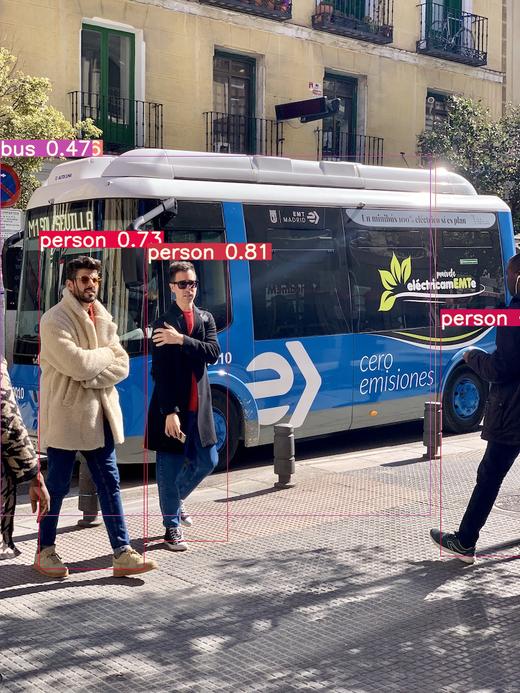

In [ ]:
showImage("/content/gdrive/My Drive/development/ai/4-yolov3/output/56_bus.jpg", 520)